### Import the Neccessary Libraries

In [1]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### 1. Data Preprocessing
#### Loading the Data

In [2]:
with open('DB_youtube.json', 'r', encoding='utf-8') as file:
    youtube = json.load(file)

# Converting the data into a DataFrame
df = pd.DataFrame(youtube)
df.head()


,Title,Video ID,Published at,Description,Category ID,Comment Count,Comments
0,10 ICONIC David Beckham goals you'll NEVER forget,oTpTVqJX8ho,2023-12-11T16:01:00Z,10 of the best Premier League goals scored by ...,17,627,"[Favourite David Beckham goal?, Goals before I..."
1,"David Beckham SURPRISES Thierry Henry, Jamie C...",wFDSJuqg0Vk,2024-09-17T19:56:02Z,"David Beckham surprised Kate Abdo, Jamie Carra...",17,1822,"[MY HERO!!😂😂😂, As if David lets his mom cut hi..."
2,David Beckham Embraces the Moment While Eating...,igmUnkx0fBw,2024-08-29T15:00:45Z,David Beckham takes on the Hot Ones gauntlet f...,24,4265,[Yet further evidence that David Beckham is on...
3,David Beckham on Spice Girls Reuniting for Vic...,rniYjUoNbOU,2024-05-09T06:00:23Z,"David talks about his honey, owning the Miami ...",23,771,"[Amazing performance mate&#39;s, changed game...."
4,Unbelievable David beckham 3 balls into a tras...,2lvRv2mnYLU,2011-04-08T06:48:00Z,You be the judge of this Pepsi video with LA G...,17,3653,"[هذه معجزة سدد كالغولف افضل, بيكهام اوقف هذه ا..."


### Check for Missing Values

In [3]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
Title            0
Video ID         0
Published at     0
Description      0
Category ID      0
Comment Count    0
Comments         0
dtype: int64


### Check for Duplicate Values

In [4]:
duplicates = df.duplicated(subset=['Video ID']).sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(subset=['Video ID'], inplace=True)

Number of duplicate rows: 0


### Advanced Preprocessing

In [5]:
# Function for clean text
def clean_text(text):
    # Removing URLs and special characters, convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower().strip()

# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

In [6]:
# Cleaning and filtering non-English titles, descriptions, and comments
df['Cleaned_Title'] = df['Title'].apply(lambda x: clean_text(str(x)) if is_english(str(x)) else '')
df['Cleaned_Description'] = df['Description'].apply(lambda x: clean_text(str(x)) if is_english(str(x)) else '')
df['Cleaned_Comments'] = df['Comments'].apply(lambda comments: [clean_text(comment) for comment in comments if is_english(comment)])

In [7]:
# Expand contractions for each column separately
df['Expanded_Title'] = df['Cleaned_Title'].apply(contractions.fix)
df['Expanded_Description'] = df['Cleaned_Description'].apply(contractions.fix)
df['Expanded_Comments'] = df['Cleaned_Comments'].apply(lambda comments: [contractions.fix(comment) for comment in comments])

### Tokenization

In [8]:
# Tokenization for title, description, and comments
df['Title_Tokens'] = df['Expanded_Title'].apply(word_tokenize)
df['Description_Tokens'] = df['Expanded_Description'].apply(word_tokenize)
df['Comments_Tokens'] = df['Expanded_Comments'].apply(lambda comments: [word_tokenize(comment) for comment in comments])

### Stopwords Removal

In [9]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['Title_Tokens'] = df['Title_Tokens'].apply(remove_stopwords)
df['Description_Tokens'] = df['Description_Tokens'].apply(remove_stopwords)
df['Comments_Tokens'] = df['Comments_Tokens'].apply(lambda comments: [remove_stopwords(comment) for comment in comments])

### Lemmatization

In [10]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df['Title_Tokens'] = df['Title_Tokens'].apply(lemmatize_tokens)
df['Description_Tokens'] = df['Description_Tokens'].apply(lemmatize_tokens)
df['Comments_Tokens'] = df['Comments_Tokens'].apply(lambda comments: [lemmatize_tokens(comment) for comment in comments])



In [11]:
# Printing the processed data
processed_columns = ['Title', 'Cleaned_Title', 'Title_Tokens', 'Description', 'Cleaned_Description', 'Description_Tokens', 'Comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(5))


Processed Data:
                                               Title  \
0  10 ICONIC David Beckham goals you'll NEVER forget   
1  David Beckham SURPRISES Thierry Henry, Jamie C...   
2  David Beckham Embraces the Moment While Eating...   
3  David Beckham on Spice Girls Reuniting for Vic...   
4  Unbelievable David beckham 3 balls into a tras...   

                                       Cleaned_Title  \
0      iconic david beckham goals youll never forget   
1  david beckham surprises thierry henry jamie ca...   
2  david beckham embraces the moment while eating...   
3  david beckham on spice girls reuniting for vic...   
4  unbelievable david beckham  balls into a trash...   

                                        Title_Tokens  \
0      [iconic, david, beckham, goal, never, forget]   
1  [david, beckham, surprise, thierry, henry, jam...   
2  [david, beckham, embrace, moment, eating, spic...   
3  [david, beckham, spice, girl, reuniting, victo...   
4        [unbelievable, david

### Term Frequency

In [13]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

# Function to process text: tokenize, remove stopwords, and lemmatize
def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

term_freq_counter = Counter()

# Processing each row in the DataFrame and update term frequency counts
for _, row in df.iterrows():
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_description = process_text(row['Cleaned_Description'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_description)
    term_freq_counter.update(tokens_comments)

# Display the most common terms
freq_num = 50  # Number of most frequent terms to display
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

Top 50 most common terms:
beckham: 157
david: 128
like: 84
man: 48
one: 47
football: 41
love: 41
time: 41
world: 39
player: 39
goal: 34
show: 34
u: 33
game: 33
league: 31
ra: 31
beckhams: 31
england: 30
even: 29
legend: 29
real: 29
year: 28
video: 27
best: 26
get: 26
kick: 25
would: 25
great: 25
look: 25
dont: 24
he: 24
never: 23
know: 23
subscribe: 23
messi: 23
really: 22
well: 22
victoria: 22
free: 21
make: 21
good: 21
im: 21
people: 21
new: 21
thats: 20
got: 20
still: 20
jimmy: 20
see: 20
match: 19


### Visualize the Top 20 words from term frequency

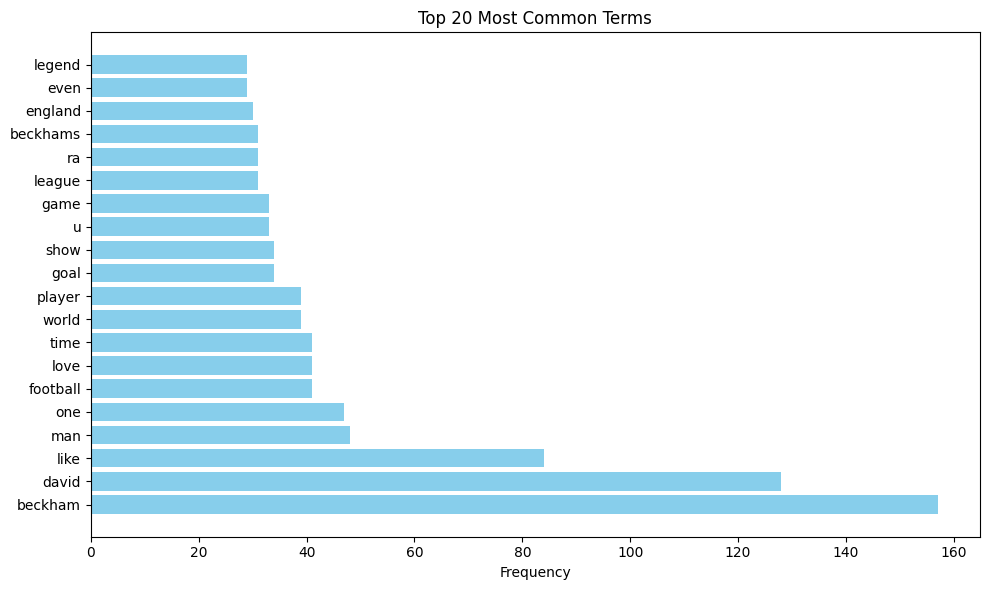

In [14]:
# Extract the top 20 most common terms
common_terms = term_freq_counter.most_common(20)
terms = [term for term, count in common_terms]
counts = [count for term, count in common_terms]

# Create the plot
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(terms))
plt.barh(y_pos, counts, color='skyblue')
plt.yticks(y_pos, terms)
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Terms')

# Show the plot
plt.tight_layout()
plt.show()


### Wordcloud for top 50 terms

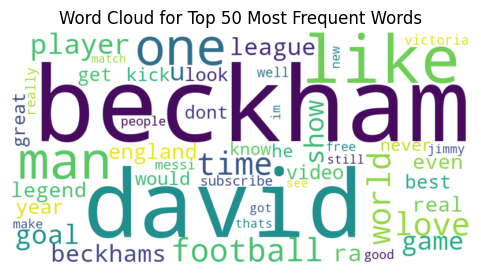

In [15]:
# Extract the top 50 terms and their frequencies
top_50_words = dict(term_freq_counter.most_common(50))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_50_words)

# Plot the word cloud
plt.figure(figsize=(6, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud for Top 50 Most Frequent Words')
plt.show()


## 2. Data Modeling
### TF-IDF Vectorization 

#### Cleaned Description Vectorization

In [16]:
tfidf_vectorizer_description = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english', ngram_range=(1, 2))

tfidf_description_matrix = tfidf_vectorizer_description.fit_transform(df['Cleaned_Description'])

description_feature_names = tfidf_vectorizer_description.get_feature_names_out()

# Display TF-IDF matrix for Cleaned_Description (first 5 rows)
description_tfidf_df = pd.DataFrame(tfidf_description_matrix.toarray(), columns=description_feature_names)
print("TF-IDF Matrix for Cleaned_Description:")
print(description_tfidf_df.head(n=10))

TF-IDF Matrix for Cleaned_Description:
    beckham     david  david beckham  facebook  football  instagram  subscribe
0  0.397046  0.423894       0.501738  0.339970  0.326009   0.355147   0.250869
1  0.295314  0.315283       0.373181  0.505724  0.000000   0.528301   0.373181
2  0.749291  0.266652       0.315621  0.000000  0.410155   0.000000   0.315621
3  0.216349  0.230978       0.000000  0.740995  0.355282   0.387037   0.273395
4  0.770560  0.411333       0.486870  0.000000  0.000000   0.000000   0.000000
5  0.000000  0.150353       0.000000  0.241172  0.925071   0.251938   0.000000
6  1.000000  0.000000       0.000000  0.000000  0.000000   0.000000   0.000000
7  0.190137  0.405987       0.240271  0.325609  0.000000   0.340145   0.720814
8  0.433003  0.462282       0.547176  0.000000  0.000000   0.000000   0.547176
9  0.651172  0.347602       0.000000  0.000000  0.534668   0.000000   0.411435


#### Cleaned Comments Vectorization

In [17]:
df['Combined_Comments'] = df['Cleaned_Comments'].apply(lambda comments: ' '.join(comments))

tfidf_vectorizer_comments = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english', ngram_range=(1, 2))

tfidf_comments_matrix = tfidf_vectorizer_comments.fit_transform(df['Combined_Comments'])

comments_feature_names = tfidf_vectorizer_comments.get_feature_names_out()

comments_tfidf_df = pd.DataFrame(tfidf_comments_matrix.toarray(), columns=comments_feature_names)
print("\nTF-IDF Matrix for Combined_Comments:")
print(comments_tfidf_df.head())



TF-IDF Matrix for Combined_Comments:
      best     david  david beckham       did     didnt      dont   england  \
0  0.34862  0.277836       0.321928  0.000000  0.000000  0.000000  0.000000   
1  0.00000  0.326354       0.000000  0.196631  0.000000  0.204749  0.196631   
2  0.00000  0.615018       0.237540  0.082345  0.000000  0.000000  0.082345   
3  0.00000  0.609987       0.117798  0.000000  0.000000  0.127565  0.122507   
4  0.00000  0.160150       0.185566  0.000000  0.218912  0.000000  0.192983   

   football      good       got  ...    people    player    really     right  \
0  0.000000  0.000000  0.160964  ...  0.000000  0.000000  0.174310  0.154945   
1  0.213518  0.213518  0.189073  ...  0.000000  0.000000  0.000000  0.000000   
2  0.178834  0.089417  0.000000  ...  0.000000  0.082345  0.171490  0.076219   
3  0.133028  0.000000  0.000000  ...  0.133028  0.122507  0.127565  0.226787   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.178627   

      

#### Combined Description and Comments TF-IDF Vectorization

In [18]:
df['Combined_Text'] = df['Cleaned_Description'] + ' ' + df['Cleaned_Comments'].apply(lambda comments: ' '.join(comments))

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9,  
    min_df=5,     
    stop_words='english',
    ngram_range=(1, 2)  
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['Combined_Text'])

feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print("\nSample TF-IDF Features:")
print(feature_names[:10])  

Number of features: 186

Sample TF-IDF Features:
['absolutely' 'actually' 'amazing' 'awesome' 'ball' 'beautiful' 'beckhams'
 'becks' 'believe' 'best']


### Vader Sentiment Anlaysis

#### Description and Comments Sentiment analysis

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment and return compound score
def analyze_sentiment(text):
    if text:  
        sentiment = analyzer.polarity_scores(text)
        return sentiment['compound']  
    return 0  

# Categorize the sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis and categorization to both Description and Comments
df['Description_Sentiment_Score'] = df['Cleaned_Description'].apply(analyze_sentiment)
df['Description_Sentiment'] = df['Description_Sentiment_Score'].apply(categorize_sentiment)

df['Comments_Sentiment_Score'] = df['Combined_Comments'].apply(analyze_sentiment)
df['Comments_Sentiment'] = df['Comments_Sentiment_Score'].apply(categorize_sentiment)

# Display sentiment analysis results
print("\nSentiment Analysis for Cleaned_Description:")
print(df[['Cleaned_Description', 'Description_Sentiment_Score', 'Description_Sentiment']].head())

print("\nSentiment Analysis for Combined_Comments:")
print(df[['Combined_Comments', 'Comments_Sentiment_Score', 'Comments_Sentiment']].head())


Sentiment Analysis for Cleaned_Description:
                                 Cleaned_Description  \
0  of the best premier league goals scored by for...   
1  david beckham surprised kate abdo jamie carrag...   
2  david beckham takes on the hot ones gauntlet f...   
3  david talks about his honey owning the miami f...   
4  you be the judge of this pepsi video with la g...   

   Description_Sentiment_Score Description_Sentiment  
0                       0.9218              positive  
1                       0.8516              positive  
2                       0.9179              positive  
3                       0.9523              positive  
4                      -0.5423              negative  

Sentiment Analysis for Combined_Comments:
                                   Combined_Comments  \
0  favourite david beckham goal goals before i wa...   
1  as if david lets his mom cut his hair how high...   
2  yet further evidence that david beckham is one...   
3  amazing performanc

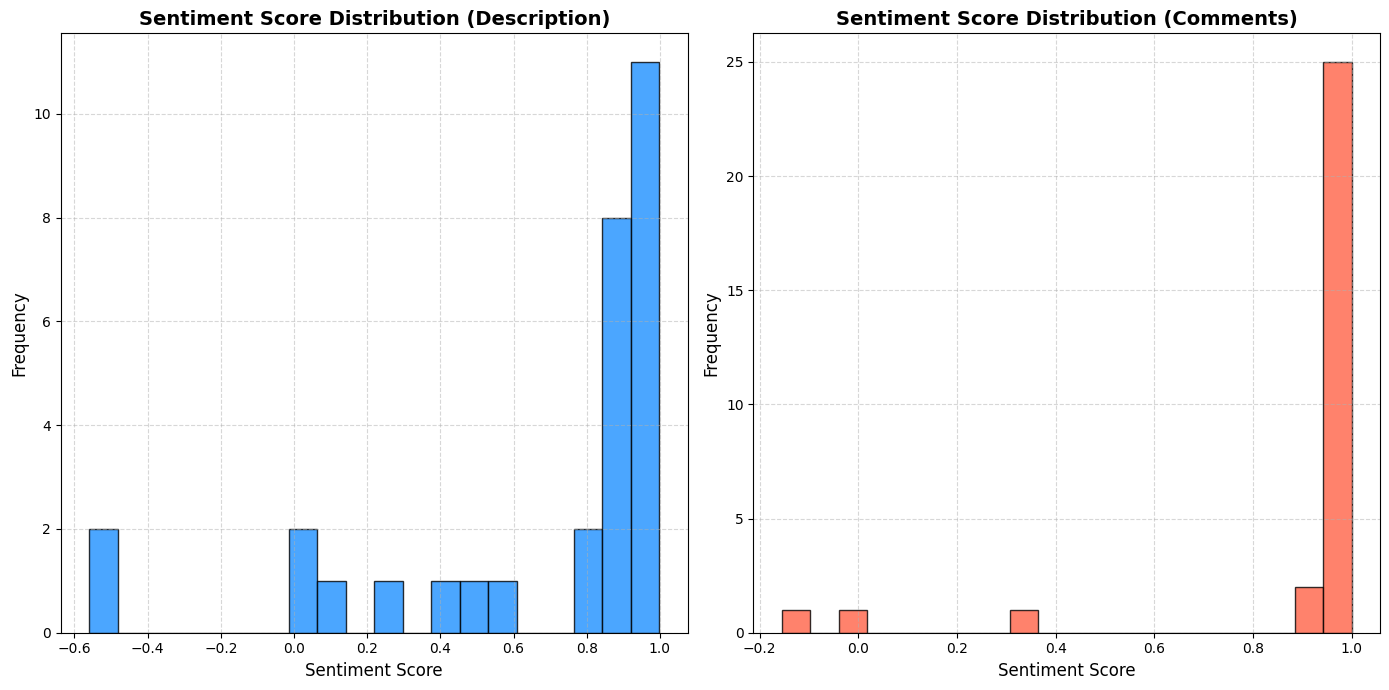

In [20]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(df['Description_Sentiment_Score'], bins=20, color='dodgerblue', edgecolor='black', alpha=0.8)
plt.title('Sentiment Score Distribution (Description)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 2, 2)
plt.hist(df['Comments_Sentiment_Score'], bins=20, color='tomato', edgecolor='black', alpha=0.8)
plt.title('Sentiment Score Distribution (Comments)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

# Display the plots
plt.show()


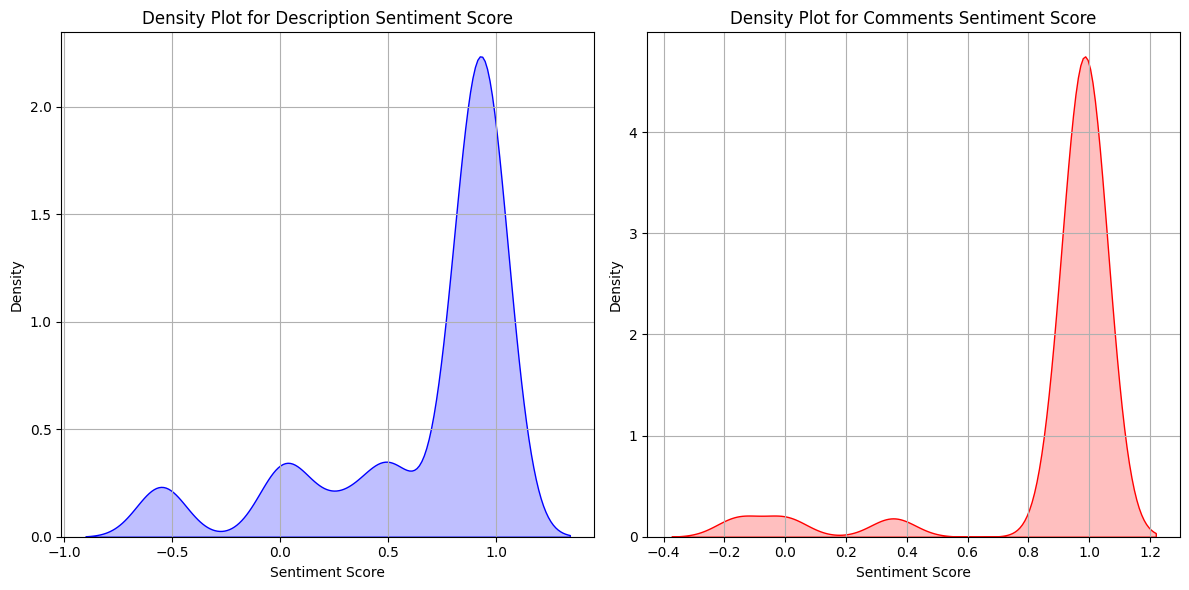

In [21]:
# Density plot for Description sentiment scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(df['Description_Sentiment_Score'], fill=True, color='blue', bw_adjust=0.5)
plt.title('Density Plot for Description Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.grid(True)

# Density plot for Comments sentiment scores
plt.subplot(1, 2, 2)
sns.kdeplot(df['Comments_Sentiment_Score'], fill=True, color='red', bw_adjust=0.5)
plt.title('Density Plot for Comments Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()


#### Combined Sentiment Analysis of Description and Comments

In [22]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment and return compound score
def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  

# Function to categorize the sentiment based on compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Assuming 'Combined_Text' is a combination of Cleaned_Description and Cleaned_Comments
# Apply sentiment analysis and categorization for Combined Text
df['Combined_Sentiment_Score'] = df['Combined_Text'].apply(analyze_sentiment)
df['Combined_Sentiment'] = df['Combined_Sentiment_Score'].apply(categorize_sentiment)

# Display sample sentiment analysis results
print("\nSample Sentiment Scores and Categories:")
print(df[['Combined_Text', 'Combined_Sentiment_Score', 'Combined_Sentiment']].head())



Sample Sentiment Scores and Categories:
                                       Combined_Text  \
0  of the best premier league goals scored by for...   
1  david beckham surprised kate abdo jamie carrag...   
2  david beckham takes on the hot ones gauntlet f...   
3  david talks about his honey owning the miami f...   
4  you be the judge of this pepsi video with la g...   

   Combined_Sentiment_Score Combined_Sentiment  
0                    0.9958           positive  
1                    0.9950           positive  
2                    0.9994           positive  
3                    0.9981           positive  
4                    0.9338           positive  


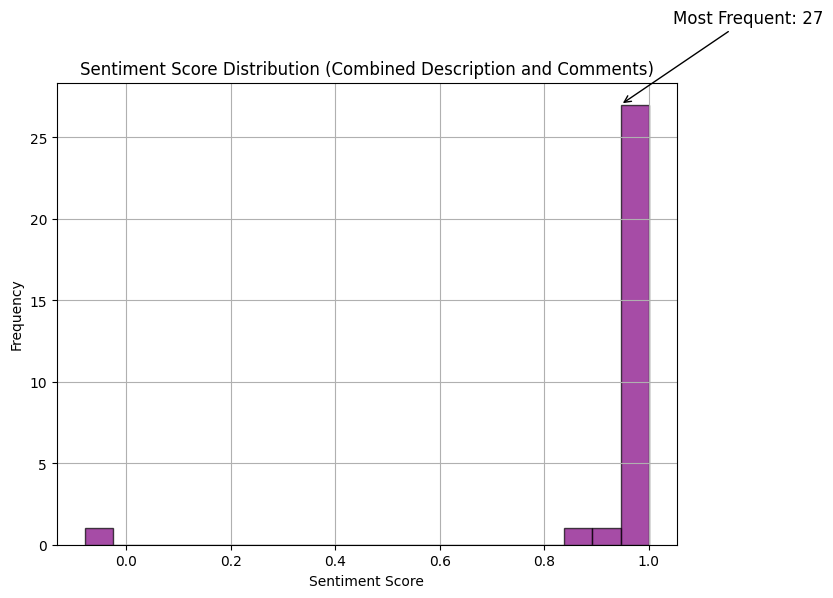

In [23]:
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(df['Combined_Sentiment_Score'], bins=20, color='purple', edgecolor='black', alpha=0.7)

max_bin_index = np.argmax(n)
plt.annotate(f'Most Frequent: {int(n[max_bin_index])}', 
             xy=(bins[max_bin_index], n[max_bin_index]), 
             xytext=(bins[max_bin_index] + 0.1, n[max_bin_index] + 5), 
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12)

plt.title('Sentiment Score Distribution (Combined Description and Comments)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


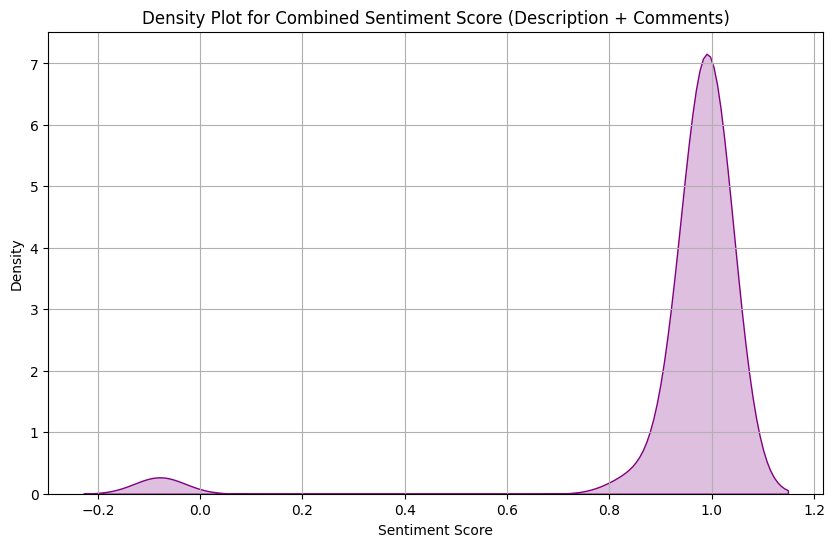

In [24]:
# Plot the density of the sentiment scores with fill
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Combined_Sentiment_Score'], fill=True, color='purple', bw_adjust=0.5)
plt.title('Density Plot for Combined Sentiment Score (Description + Comments)')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.grid(True)  # For better readability
plt.show()


### Wordcloud for Combined comments and description

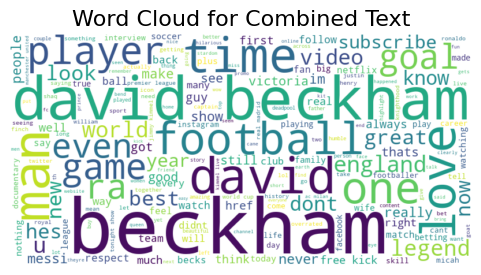

In [25]:
combined_text = ' '.join(df['Combined_Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='viridis').generate(combined_text)

plt.figure(figsize=(6, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis lines and labels
plt.title('Word Cloud for Combined Text', fontsize=16)
plt.show()


## 3. Topic Modeling
### LDA Modeling

In [26]:
vectorizer = CountVectorizer(
    max_df=0.9,  
    min_df=5,   
    stop_words='english',
    ngram_range=(1, 2)  
)

dtm = vectorizer.fit_transform(df['Combined_Text'])

print(f"Document-Term Matrix Shape: {dtm.shape}")


Document-Term Matrix Shape: (30, 186)


In [27]:
lda_model_sklearn = LatentDirichletAllocation(n_components=10, random_state=100)
lda_model_sklearn.fit(dtm)

print("\nLDA Model Training Completed")



LDA Model Training Completed


In [28]:
feature_names = vectorizer.get_feature_names_out()

num_top_words = 20  # You can adjust this number to display more or fewer words per topic

print("\nLDA Model Topics:")
for idx, topic in enumerate(lda_model_sklearn.components_):
    print(f"Topic {idx}:")
    top_words_idx = topic.argsort()[:-num_top_words - 1:-1]  # Get the indices of the top 10 words
    top_words = [feature_names[i] for i in top_words_idx]  # Map indices to words
    print(" ".join(top_words))
    print("\n")



LDA Model Topics:
Topic 0:
great history hes david beckham family people new work did david years wife th does website captain left live king becks


Topic 1:
league like david just england world david beckham ball best game becks href goal guys man team match united does football


Topic 2:
new makes make man real seeing watching game just match doing better want amazing shorts got time ive think games


Topic 3:
david like love just victoria good dont time know really follow people man family thats netflix david beckham way great think


Topic 4:
watch subscribe legend david love href channel becks man club ronaldo guys career miss took games davids youtube mean thats


Topic 5:
ronaldo long guys dont time career remember sure subscribe did tell good absolutely got makes seeing like miss watch video


Topic 6:
david david beckham respect man hes time just like im legend guy football love did doing world world cup amazing cup wife


Topic 7:
david david beckham player like live footb

### Label the topics generated through LDA Model

In [29]:
topic_names = {
    0: "David Beckham’s History and Achievements",
    1: "Football Matches and Game Highlights",
    2: "Match Insights and David Beckham’s Strategy",
    3: "Victoria Beckham and David’s Family Life",
    4: "David Beckham’s Club and Fans",
    5: "Football Career and Legacy of Ronaldo and Beckham",
    6: "David Beckham’s Football Skills and World Cup Performance",
    7: "Real Madrid and Beckham’s Performance in Football",
    8: "Football Achievements and Messi vs Beckham",
    9: "Real Madrid and Beckham’s Role in Football"
}

print("\nLDA Model Topics with Allocated Names:")
for idx, topic in enumerate(lda_model_sklearn.components_):
    topic_name = topic_names.get(idx, f"Topic {idx}")
    print(f"{topic_name}:")

    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get the indices of the top 10 words
    top_words = [feature_names[i] for i in top_words_idx]  # Map indices to words
    print(" ".join(top_words))
    print("\n")



LDA Model Topics with Allocated Names:
David Beckham’s History and Achievements:
great history hes david beckham family people new work did david


Football Matches and Game Highlights:
league like david just england world david beckham ball best game


Match Insights and David Beckham’s Strategy:
new makes make man real seeing watching game just match


Victoria Beckham and David’s Family Life:
david like love just victoria good dont time know really


David Beckham’s Club and Fans:
watch subscribe legend david love href channel becks man club


Football Career and Legacy of Ronaldo and Beckham:
ronaldo long guys dont time career remember sure subscribe did


David Beckham’s Football Skills and World Cup Performance:
david david beckham respect man hes time just like im legend


Real Madrid and Beckham’s Performance in Football:
david david beckham player like live football free best use overrated


Football Achievements and Messi vs Beckham:
messi video beckhams years goal old world

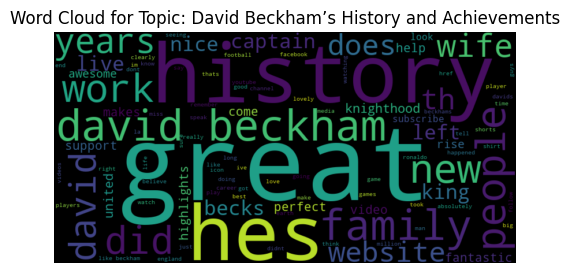

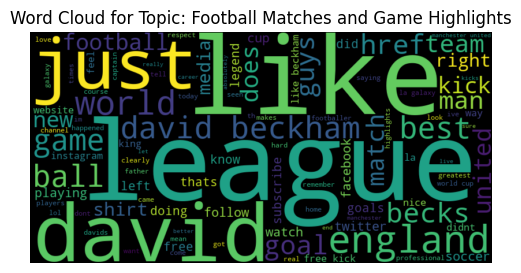

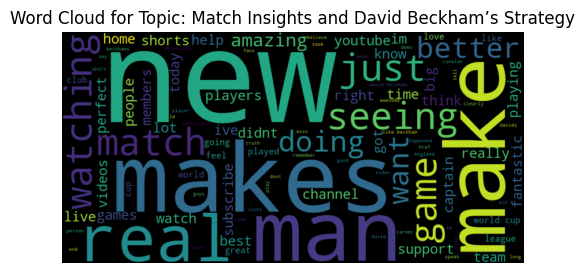

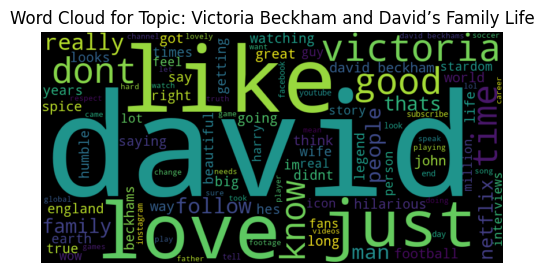

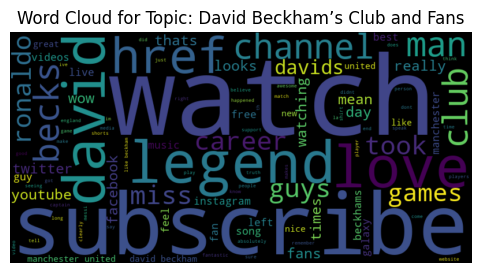

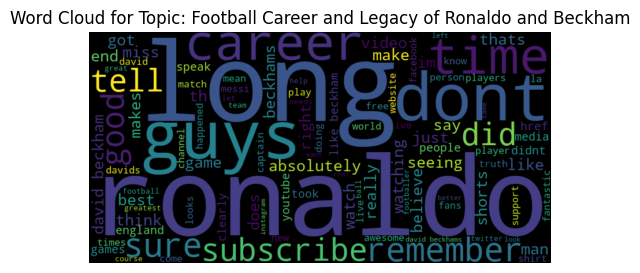

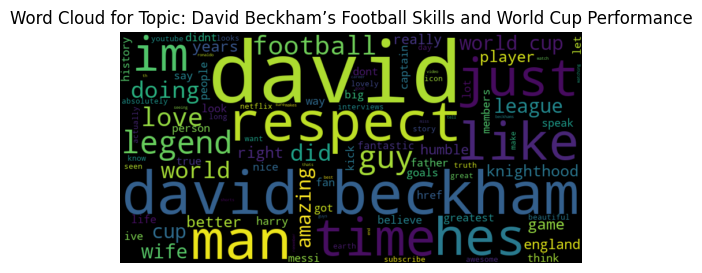

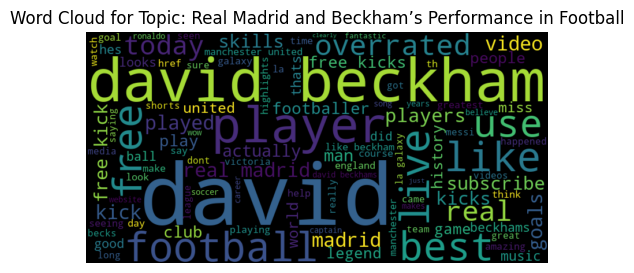

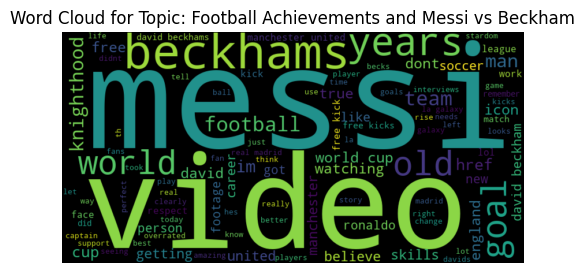

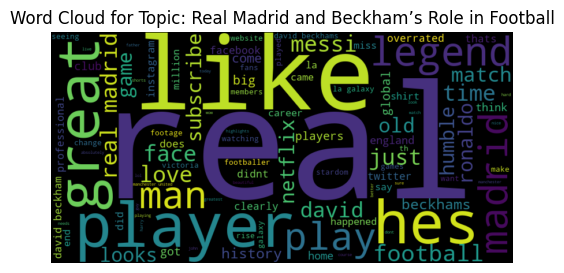

In [30]:
def plot_wordcloud_for_topics(lda_model, feature_names, topic_names, num_words=10):
    for idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-num_words - 1:-1]
        top_words = {feature_names[i]: topic[i] for i in top_words_idx}
        
        wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top_words)
        plt.figure(figsize=(6, 3))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for Topic: {topic_names[idx]}")
        plt.axis("off")
        plt.show()

plot_wordcloud_for_topics(lda_model_sklearn, feature_names, topic_names, num_words=100)
